# Analysis for IndeLLM 

This notebook shows the analysis as well as creating of the main and supplementary figures for sections prestented in the article. 

# Imports

First, we imported all the datasets: Indels_Full (extended dataset with 7500 indels). We also do analysis on dataset splits (Cannon et al. subset with scores from nine predictions tools for 3478 indels, and the training, Validation and Test datasets).
Second, we imported all the resulting scores from the 8 different PLM runs. All the scoring tables include Brandes and IndeLLM scores for the wildtype and mutated sequences. We also import the prediction scores from our siamese network, splitted training, validation and test dataset.  
For all indel dataset, scores and PLM we calcualted the AUC, MCC and F1. These precalculated scores are loaded in a metrics table. 


In [29]:
import pandas as pd

#Import datasets
alldata = pd.read_csv("../Data/Indels.csv")
Cannonetal = pd.read_csv("Indels_Cannonetal.csv")
train = pd.read_csv("../Data/train.csv")
val = pd.read_csv("../Data/val.csv")
test = pd.read_csv("../Data/test.csv")

#import scores per PLM
scoresESM1b = pd.read_csv("../Data/scores_ESM1b.csv")
scoresESM1v = pd.read_csv("../Data/scores_ESM1v.csv")
scoresESM2_3B = pd.read_csv("../Data/scores_ESM2_3B.csv")
scoresESM2_150M = pd.read_csv("../Data/scores_ESM2_150M.csv")
scoresESM2_650M = pd.read_csv("../Data/scores_ESM2_650M.csv")
scoresESM2_650M_masked = pd.read_csv("../Data/scores_ESM2_650M_masked.csv")
scoresESM3 = pd.read_csv("../Data/scores_ESM3.csv")
scoresProtTrans = pd.read_csv("../Data/scores_ProtBert.csv")

#Import siamese model scores
siamese_m4_train = pd.read_csv("siamese_m4_train.csv")
siamese_m4_val = pd.read_csv("siamese_m4_val.csv")
siamese_m4_test = pd.read_csv("siamese_m4_test.csv")
siamese_m4_alldata = pd.read_csv("siamese_m4_alldata.csv")

#import dataset with metrics
metrics_df = pd.read_csv("metrics.csv", index_col='Model')


# Section 4.1 Efficient scoring approach for zero-shot inference using PLMs
To find the efficient scoring approach we opted to use the scores from ESM2 650M parameters. 

From the resulting scores we need to substract the wildtype score from the mutation score for find the IndeLLM, IndeLLM masked and Brandes scores for each indel. 
We used the aboslute number for IndeLLM abs and Brandes abs. 

In [30]:
scoresESM2_650M['dif_IndeLLM'] = scoresESM2_650M['IndeLLM_mut'] - scoresESM2_650M['IndeLLM_wt'] # IndeLLM
scoresESM2_650M['dif_IndeLLM_abs'] = abs(scoresESM2_650M['IndeLLM_mut'] - scoresESM2_650M['IndeLLM_wt']) # IndeLLM abs
scoresESM2_650M_masked['dif_IndeLLM'] = scoresESM2_650M_masked['IndeLLM_mut'] - scoresESM2_650M_masked['IndeLLM_wt'] # IndeLLM masked
scoresESM2_650M['dif_Brandes'] = scoresESM2_650M['Brandes_mut'] - scoresESM2_650M['Brandes_wt'] # Brandes
scoresESM2_650M['dif_Brandes_abs'] = abs(scoresESM2_650M['Brandes_mut'] - scoresESM2_650M['Brandes_wt']) # Brandes abs

### Performace analysis of scoring approaches
We evaluate the performace of the scoring approaches by calculation of false and true positives, AUC, F1-score and MCC. These scores are calculated using sklearn and saved in the metrics file

### Plotting of Main Figure 1A-B

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_16374/1049006226.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(fontsize = 8, frameon=False)


Text(0.0, 1.0, 'B) MCC scores for ESM2 650M Scoring methods')

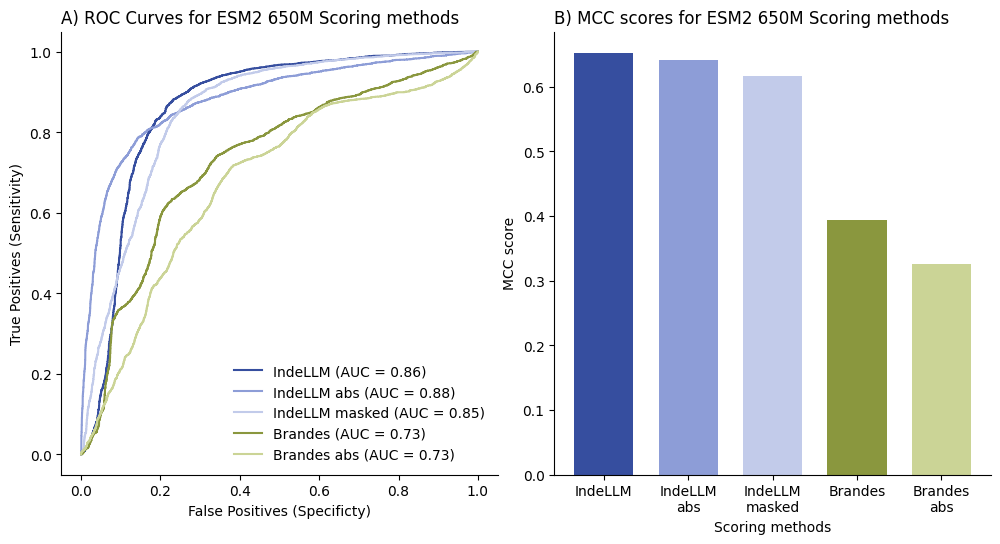

In [31]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix

fpr_ESM2650M_IndeLLM, tpr_ESM2650M_IndeLLM, thersholds_ESM2650M_IndeLLM = metrics.roc_curve(alldata['label'].values, scoresESM2_650M['dif_IndeLLM'].values, pos_label=0)
fpr_ESM2650M_IndeLLM_abs, tpr_ESM2650M_IndeLLM_abs, thersholds_ESM2650M_IndeLLM_abs = metrics.roc_curve(alldata['label'].values, scoresESM2_650M['dif_IndeLLM_abs'].values, pos_label=1) #abs scores are flipped
fpr_ESM2650M_masked_IndeLLM, tpr_ESM2650M_masked_IndeLLM, thersholds_ESM2650M_masked_IndeLLM = metrics.roc_curve(alldata['label'].values, scoresESM2_650M_masked['dif_IndeLLM'].values, pos_label=0)
fpr_ESM2650M_Brandes, tpr_ESM2650M_Brandes, thersholds_ESM2650M_Brandes = metrics.roc_curve(alldata['label'].values, scoresESM2_650M['dif_Brandes'].values, pos_label=0)
fpr_ESM2650M_Brandes_abs, tpr_ESM2650M_Brandes_abs, thersholds_ESM2650M_Brandes_abs = metrics.roc_curve(alldata['label'].values, scoresESM2_650M['dif_Brandes_abs'].values, pos_label=1) #abs scors are flipped

colors = {
    'IndeLLM': '#364e9f',
    'IndeLLM abs': '#8d9dd7',
    'IndeLLM masked': '#C2CBEA',
    'Brandes': '#8a973e',
    'Brandes abs': '#CBD496'
}

scores_label = ['IndeLLM', 'IndeLLM\nabs', 'IndeLLM\nmasked', 'Brandes', 'Brandes\nabs']
metrics_df_filtered_scores = metrics_df.loc[[score.replace('\n', ' ') for score in scores_label], :]
n_methods = len(scores_label)
bar_width = 0.7
r1 = np.arange(n_methods)

f, axes = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(10)
f.tight_layout(pad=1)
axes[0].plot(fpr_ESM2650M_IndeLLM, tpr_ESM2650M_IndeLLM, label = "IndeLLM (AUC = "+str(round(metrics_df.loc['IndeLLM', 'AUC'], 2))+")", color = "#364e9f")
axes[0].plot(fpr_ESM2650M_IndeLLM_abs, tpr_ESM2650M_IndeLLM_abs, label = "IndeLLM abs (AUC = "+str(round(metrics_df.loc['IndeLLM abs', 'AUC'], 2))+")", color = "#8d9dd7")
axes[0].plot(fpr_ESM2650M_masked_IndeLLM, tpr_ESM2650M_masked_IndeLLM, label = "IndeLLM masked (AUC = "+str(round(metrics_df.loc['IndeLLM masked', 'AUC'], 2))+")", color = "#C2CBEA")
axes[0].plot(fpr_ESM2650M_Brandes, tpr_ESM2650M_Brandes, label = "Brandes (AUC = "+str(round(metrics_df.loc['Brandes', 'AUC'], 2))+")", color = "#8a973e")
axes[0].plot(fpr_ESM2650M_Brandes_abs, tpr_ESM2650M_Brandes_abs, label = "Brandes abs (AUC = "+str(round(metrics_df.loc['Brandes', 'AUC'], 2))+")", color = "#CBD496")
axes[0].set_xlabel('False Positives (Specificty)')
axes[0].set_ylabel('True Positives (Sensitivity)')
axes[0].set_title("A) ROC Curves for ESM2 650M Scoring methods", loc = 'left')
axes[0].legend(loc = 'best', frameon=False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].bar(r1, metrics_df_filtered_scores['MCC'], color=[colors[score.replace('\n', ' ')] for score in scores_label], width=bar_width)
axes[1].set_ylabel('MCC score')
axes[1].set_xlabel('Scoring methods')
axes[1].set_xticks(r1)
axes[1].set_xticklabels(scores_label)
axes[1].legend(fontsize = 8, frameon=False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title('B) MCC scores for ESM2 650M Scoring methods', loc = 'left')


# Supplement Material section 2, Comparing Transformer based models for Indel representation
We compared 6 PLMs using the IndeLLM scoring approach.   
We evaluate the performace of the scoring approaches by calculation of false and true positives, AUC, F1-score and MCC.

# Plotting of Figure S2A-2B

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_16374/3664812138.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(fontsize = 8, frameon=False)


Text(0.0, 1.0, 'B) MCC scores for PLMs')

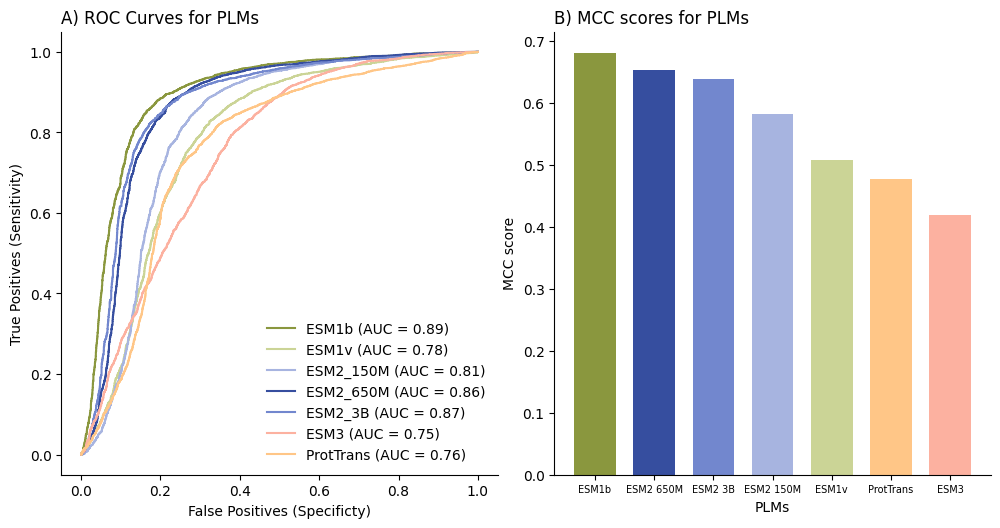

In [32]:
scoresESM1b['dif_IndeLLM'] = scoresESM1b['IndeLLM_mut'] - scoresESM1b['IndeLLM_wt']
scoresESM1v['dif_IndeLLM'] = scoresESM1v['IndeLLM_mut'] - scoresESM1v['IndeLLM_wt']
scoresESM2_3B['dif_IndeLLM'] = scoresESM2_3B['IndeLLM_mut'] - scoresESM2_3B['IndeLLM_wt']
scoresESM2_150M['dif_IndeLLM'] = scoresESM2_150M['IndeLLM_mut'] - scoresESM2_150M['IndeLLM_wt']
scoresESM3['dif_IndeLLM'] = scoresESM3['IndeLLM_mut'] - scoresESM3['IndeLLM_wt']
scoresProtTrans['dif_IndeLLM'] = scoresProtTrans['IndeLLM_mut'] - scoresProtTrans['IndeLLM_wt']

fpr_ESM1b_IndeLLM, tpr_ESM1b_IndeLLM, thersholds_ESM1b_IndeLLM = metrics.roc_curve(alldata['label'].values, scoresESM1b['dif_IndeLLM'].values, pos_label=0)
fpr_ESM1v_IndeLLM, tpr_ESM1v_IndeLLM, thersholds_ESM1v_IndeLLM = metrics.roc_curve(alldata['label'].values, scoresESM1v['dif_IndeLLM'].values, pos_label=0)
fpr_ESM23b_IndeLLM, tpr_ESM23b_IndeLLM, thersholds_ESM23b_IndeLLM = metrics.roc_curve(alldata['label'].values, scoresESM2_3B['dif_IndeLLM'].values, pos_label=0)
fpr_ESM2150M_IndeLLM, tpr_ESM2150M_IndeLLM, thersholds_ESM2150M_IndeLLM = metrics.roc_curve(alldata['label'].values, scoresESM2_150M['dif_IndeLLM'].values, pos_label=0)
fpr_ESM3_IndeLLM, tpr_ESM3_IndeLLM, thersholds_ESM3_IndeLLM = metrics.roc_curve(alldata['label'].values, scoresESM3['dif_IndeLLM'].values, pos_label=0)
fpr_ProtTrans_IndeLLM, tpr_ProtTrans_IndeLLM, thersholds_ProtTrans_IndeLLM = metrics.roc_curve(alldata['label'].values, scoresProtTrans['dif_IndeLLM'].values, pos_label=0)

PLMs = ['ESM1b', 'ESM1v', 'ESM2 3B', 'ESM2 150M', 'ESM3', 'ProtTrans']

metrics_df_filtered_plms = pd.concat([metrics_df.loc[PLMs, :], metrics_df_filtered_scores.loc[['IndeLLM']]], axis=0)
metrics_df_filtered_plms = metrics_df_filtered_plms.sort_values(by='MCC', ascending=False)

colors = {
    'ESM2 150M': '#a7b4e0',
    'IndeLLM': '#364e9f',
    'ESM2 3B': '#7287ce',
    'ESM3': '#FCB1A0',
    'ProtTrans': '#FFC687',
    'ESM1b': '#8a973e',
    'ESM1v': '#CBD496'
}

n_methods = len(colors)
bar_width = 0.7
r1 = np.arange(n_methods)

f, axes = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(10)
f.tight_layout(pad=1)

axes[0].plot(fpr_ESM1b_IndeLLM, tpr_ESM1b_IndeLLM, label = "ESM1b (AUC = "+str(round(metrics_df_filtered_plms.loc['ESM1b', 'AUC'],2))+")", color = "#8a973e")
axes[0].plot(fpr_ESM1v_IndeLLM, tpr_ESM1v_IndeLLM, label = "ESM1v (AUC = "+str(round(metrics_df_filtered_plms.loc['ESM1v', 'AUC'],2))+")", color = "#CBD496")
axes[0].plot(fpr_ESM2150M_IndeLLM, tpr_ESM2150M_IndeLLM, label = "ESM2_150M (AUC = "+str(round(metrics_df_filtered_plms.loc['ESM2 150M', 'AUC'],2))+")", color = "#a7b4e0")
axes[0].plot(fpr_ESM2650M_IndeLLM, tpr_ESM2650M_IndeLLM, label = "ESM2_650M (AUC = "+str(round(metrics_df_filtered_scores.loc['IndeLLM', 'AUC'],2))+")", color = "#364e9f")
axes[0].plot(fpr_ESM23b_IndeLLM, tpr_ESM23b_IndeLLM, label = "ESM2_3B (AUC = "+str(round(metrics_df_filtered_plms.loc['ESM2 3B', 'AUC'],2))+")", color = "#7287ce")
axes[0].plot(fpr_ESM3_IndeLLM, tpr_ESM3_IndeLLM, label = "ESM3 (AUC = "+str(round(metrics_df_filtered_plms.loc['ESM3', 'AUC'],2))+")", color = "#FCB1A0")
axes[0].plot(fpr_ProtTrans_IndeLLM, tpr_ProtTrans_IndeLLM, label = "ProtTrans (AUC = "+str(round(metrics_df_filtered_plms.loc['ProtTrans', 'AUC'],2))+")", color = "#FFC687")
axes[0].set_xlabel('False Positives (Specificty)')
axes[0].set_ylabel('True Positives (Sensitivity)')
axes[0].set_title("A) ROC Curves for PLMs", loc = 'left')
axes[0].legend(loc = 'best', frameon=False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].bar(r1, metrics_df_filtered_plms['MCC'], color=[colors[score] for score in metrics_df_filtered_plms.index], width=bar_width)
axes[1].set_ylabel('MCC score')
axes[1].set_xlabel('PLMs')
axes[1].set_xticks(r1, ['ESM1b', 'ESM2 650M', 'ESM2 3B', 'ESM2 150M', 'ESM1v', 'ProtTrans', 'ESM3'], fontsize = 7)
axes[1].legend(fontsize = 8, frameon=False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title('B) MCC scores for PLMs', loc = 'left')

# 4.2 Leveraging transfer learning and siamese networks for Indel prediction.

We build four different siamese network models.   
We evaluate the performace of the models by calculation of false and true positives, AUC, F1-score and MCC and comparing to IndeLLM scoring. 

# Plotting of Figure 2C

Text(0.0, 1.0, 'C) Scores for Siamese Networks Models')

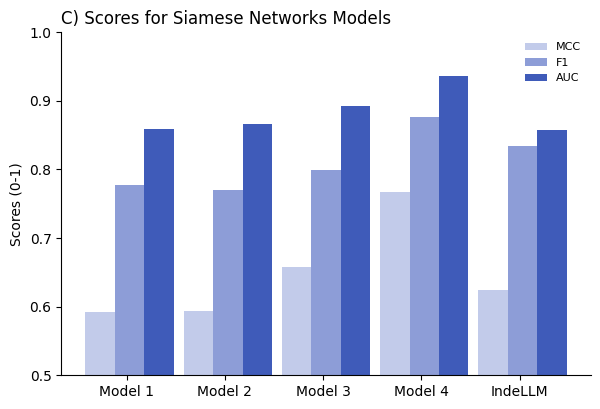

In [33]:
scores_siamese = ['Model 1 outputmean test', 'Model 2 outputmean test', 'Model 3 outputmean test', 'Model 4 outputmean test', 'IndeLLM test']
scores_label = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'IndeLLM']

metrics_df_filtered_sieamese = metrics_df.loc[scores_siamese, :]

n_methods = len(scores_siamese)
bar_width = 0.3
r1 = np.arange(n_methods)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

f, axes = plt.subplots(1,1)
f.set_figheight(4)
f.set_figwidth(6)
f.tight_layout(pad=1)
plt.bar(r1, metrics_df_filtered_sieamese['MCC'],  width=bar_width, label = 'MCC', color = '#C2CBEA')
plt.bar(r2, metrics_df_filtered_sieamese['F1'], width=bar_width, label = 'F1', color = '#8d9dd7')
plt.bar(r3, metrics_df_filtered_sieamese['AUC'], width=bar_width, label = 'AUC', color = '#3f5bb9')
plt.ylabel('Scores (0-1)')
plt.xticks([r + (0.9*bar_width) for r in range(n_methods)], labels = scores_label)
plt.legend(fontsize = 8, frameon=False)
plt.ylim([0.5, 1])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('C) Scores for Siamese Networks Models', loc = 'left')

# 4.3 Comparing Indel predictors performance to the IndeLLM scoring approach and siamese model.

In order to compare IndeLLM and IndeLLM siamese to other indel pathogenicity prediction tools we used the Cannon et al. published dataset. 

First, we used the Cannon et al. subset (3478) indels identify which of the nine methods that preformes best, compared to IndeLLM and Brandes scores.
Second, we split the Cannon et al. subset by indel origin (DDD and ClinVar, 254 and 2577 indels respectively) to evalute potential overfitting.  
Third, we evaluate four methods (IndeLLM, IndeLLM siamese, Provean and MutPred-indel) for all the indel from the extended dataset (7500 indels), the training (5960 indels), validation (819 indels) and test (721 indels) datasets. 
Fourth, we evaluated the confusion matrixes for IndeLLM and IndeLLM siamese and looked into the imbalance for the insertions by calculated the mean value and lenght of inserted amino acids.  

# Plotting Supplement Material Figure S3

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_16374/843184949.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(fontsize = 8, frameon=False)


Text(0.0, 1.0, 'B) MCC scores for indel predictors')

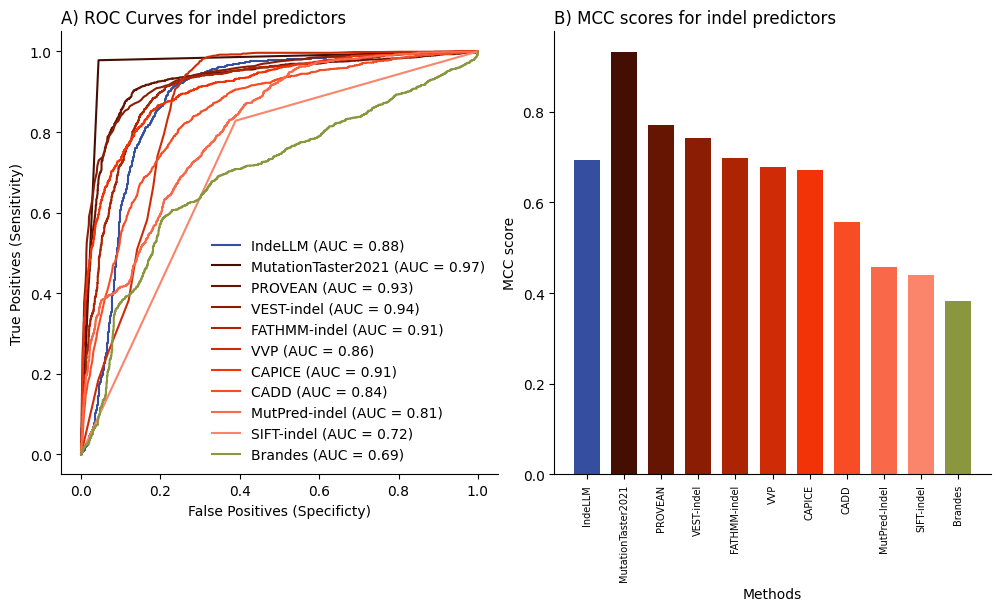

In [34]:
#Import IndeLLM and Brandes scores into Cannonetal dataset by id
IndeLLM_Brandes_scores = Cannonetal.merge(scoresESM2_650M[['id', 'dif_IndeLLM', 'dif_Brandes']], on='id', how='left')
Cannonetal['IndeLLM'] = IndeLLM_Brandes_scores['dif_IndeLLM']
Cannonetal['Brandes'] = IndeLLM_Brandes_scores['dif_Brandes']

pred_CADD = Cannonetal['CADD_Cannonetal'].values
pred_CAPICE = Cannonetal['CAPICE_Cannonetal'].values
pred_FATHMM = Cannonetal['FATHMM_Cannonetal'].values
pred_MutPred = Cannonetal['MutPred_Cannonetal'].values
Cannonetal['MutationTaster2021_bin'] = [0 if x == 'Benign' else 1 for x in Cannonetal['MutationTaster2021_Cannonetal']] # Making numerical values
pred_MutT = Cannonetal['MutationTaster2021_bin'].values
pred_PROVEAN = Cannonetal['Provean_Cannonetal'].values
Cannonetal['SIFT_bin'] = [ 0 if x == 'neutral' else 1 for x in Cannonetal['SIFT_Cannonetal']] # Making numerical values
pred_SIFT = Cannonetal['SIFT_bin'].values
pred_VEST = Cannonetal['VEST_Cannonetal'].values
pred_VVP = Cannonetal['VVP_Cannonetal'].values
pred_IndeLLM_Cannonetal = Cannonetal['IndeLLM'].values
pred_Brandes_Cannonetal = Cannonetal['Brandes'].values

truelabels_Cannonetal = Cannonetal['label'].values 
truelabels_Cannonetal = 1 - truelabels_Cannonetal

fpr_CADD, tpr_CADD, thersholds_CADD = metrics.roc_curve(truelabels_Cannonetal, pred_CADD, pos_label=0)
fpr_CAPICE, tpr_CAPICE, thersholds_CAPICE = metrics.roc_curve(truelabels_Cannonetal, pred_CAPICE, pos_label=0)
fpr_FATHMM, tpr_FATHMM, thersholds_FATHMM = metrics.roc_curve(truelabels_Cannonetal, pred_FATHMM, pos_label=0)
fpr_MutPred, tpr_MutPred, thersholds_MutPred = metrics.roc_curve(truelabels_Cannonetal, pred_MutPred, pos_label=0)
fpr_MutT, tpr_MutT, thersholds_MutT = metrics.roc_curve(truelabels_Cannonetal, pred_MutT, pos_label=0)
fpr_PROVEAN, tpr_PROVEAN, thersholds_PROVEAN = metrics.roc_curve(truelabels_Cannonetal, pred_PROVEAN, pos_label=1)
fpr_SIFT, tpr_SIFT, thersholds_SIFT = metrics.roc_curve(truelabels_Cannonetal, pred_SIFT, pos_label=0)
fpr_VEST, tpr_VEST, thersholds_VEST = metrics.roc_curve(truelabels_Cannonetal, pred_VEST, pos_label=0)
fpr_VVP, tpr_VVP, thersholds_VVP = metrics.roc_curve(truelabels_Cannonetal, pred_VVP, pos_label=0)
fpr_IndeLLM_Cannon, tpr_IndeLLM_Cannon, thersholds_IndeLLM_Cannon = metrics.roc_curve(truelabels_Cannonetal, pred_IndeLLM_Cannonetal, pos_label=1)
fpr_Brandes_Cannon, tpr_Brandes_Cannon, thersholds_Brandes_Cannon = metrics.roc_curve(truelabels_Cannonetal, pred_Brandes_Cannonetal, pos_label=1)

colors = {
    'IndeLLM': '#364e9f',
    'MutationTaster2021': '#450e02',
    'PROVEAN': '#671503',
    'VEST-indel': '#8a1d04',
    'FATHMM-indel': '#ad2405',
    'VVP': '#cf2b06',
    'CAPICE': '#f23207',
    'CADD': '#f84c25',
    'MutPred-Indel': '#f96848',
    'SIFT-indel': '#fa856a',
    'Brandes': '#8a973e'
}
methods_cannon = ['IndeLLM Cannon', 'MutationTaster2021', 'PROVEAN', 'VEST-indel', 'FATHMM-indel', 'VVP', 'CAPICE', 'CADD', 'MutPred-Indel', 'SIFT-indel', 'Brandes Cannon']
metrics_df_filtered_cannon = metrics_df.loc[methods_cannon, :]

n_methods = len(methods_cannon)
bar_width = 0.7
r1 = np.arange(n_methods)

f, axes = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(10)
f.tight_layout(pad=1)

axes[0].plot(fpr_IndeLLM_Cannon, tpr_IndeLLM_Cannon, label = "IndeLLM (AUC = "+str(round(metrics_df.loc['IndeLLM Cannon', 'AUC'], 2))+")", color = "#364e9f")
axes[0].plot(fpr_MutT, tpr_MutT, label = "MutationTaster2021 (AUC = "+str(round(metrics_df.loc['MutationTaster2021', 'AUC'], 2))+")", color = "#450e02")
axes[0].plot(fpr_PROVEAN, tpr_PROVEAN, label = "PROVEAN (AUC = "+str(round(metrics_df.loc['PROVEAN', 'AUC'], 2))+")", color = "#671503")
axes[0].plot(fpr_VEST, tpr_VEST, label = "VEST-indel (AUC = "+str(round(metrics_df.loc['VEST-indel', 'AUC'], 2))+")", color = "#8a1d04")
axes[0].plot(fpr_FATHMM, tpr_FATHMM, label = "FATHMM-indel (AUC = "+str(round(metrics_df.loc['FATHMM-indel', 'AUC'], 2))+")", color = "#ad2405")
axes[0].plot(fpr_VVP, tpr_VVP, label = "VVP (AUC = "+str(round(metrics_df.loc['VVP', 'AUC'], 2))+")", color = "#cf2b06")
axes[0].plot(fpr_CAPICE, tpr_CAPICE, label = "CAPICE (AUC = "+str(round(metrics_df.loc['CAPICE', 'AUC'], 2))+")", color = "#f23207")
axes[0].plot(fpr_CADD, tpr_CADD, label = "CADD (AUC = "+str(round(metrics_df.loc['CADD', 'AUC'], 2))+")", color = "#f84c25")
axes[0].plot(fpr_MutPred, tpr_MutPred, label = "MutPred-indel (AUC = "+str(round(metrics_df.loc['MutPred-Indel', 'AUC'], 2))+")", color = "#f96848")
axes[0].plot(fpr_SIFT, tpr_SIFT, label = "SIFT-indel (AUC = "+str(round(metrics_df.loc['SIFT-indel', 'AUC'], 2))+")", color = "#fa856a")
axes[0].plot(fpr_Brandes_Cannon, tpr_Brandes_Cannon, label = "Brandes (AUC = "+str(round(metrics_df.loc['Brandes Cannon', 'AUC'], 2))+")", color = "#8a973e")
axes[0].set_xlabel('False Positives (Specificty)')
axes[0].set_ylabel('True Positives (Sensitivity)')
axes[0].set_title("A) ROC Curves for indel predictors", loc = 'left')
axes[0].legend(loc = 'best', frameon=False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].bar(r1, metrics_df_filtered_cannon['MCC'], color=[colors[score] for score in colors], width=bar_width)
axes[1].set_ylabel('MCC score')
axes[1].set_xlabel('Methods')
axes[1].set_xticks(r1, colors, fontsize = 7, rotation = 90, ha = 'center')
axes[1].legend(fontsize = 8, frameon=False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title('B) MCC scores for indel predictors', loc = 'left')

# Plotting Supplement Material Figure S4

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_16374/2293343655.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cannonetal_DDD['MutationTaster2021_bin'] = [0 if x == 'Benign' else 1 for x in Cannonetal_DDD['MutationTaster2021_Cannonetal']] # Making numerical values
/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_16374/2293343655.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cannonetal_DDD['SIFT_bin'] = [ 0 if x == 'neutral' else 1 for x in Cannonetal_DDD['SIFT_Cannonetal']

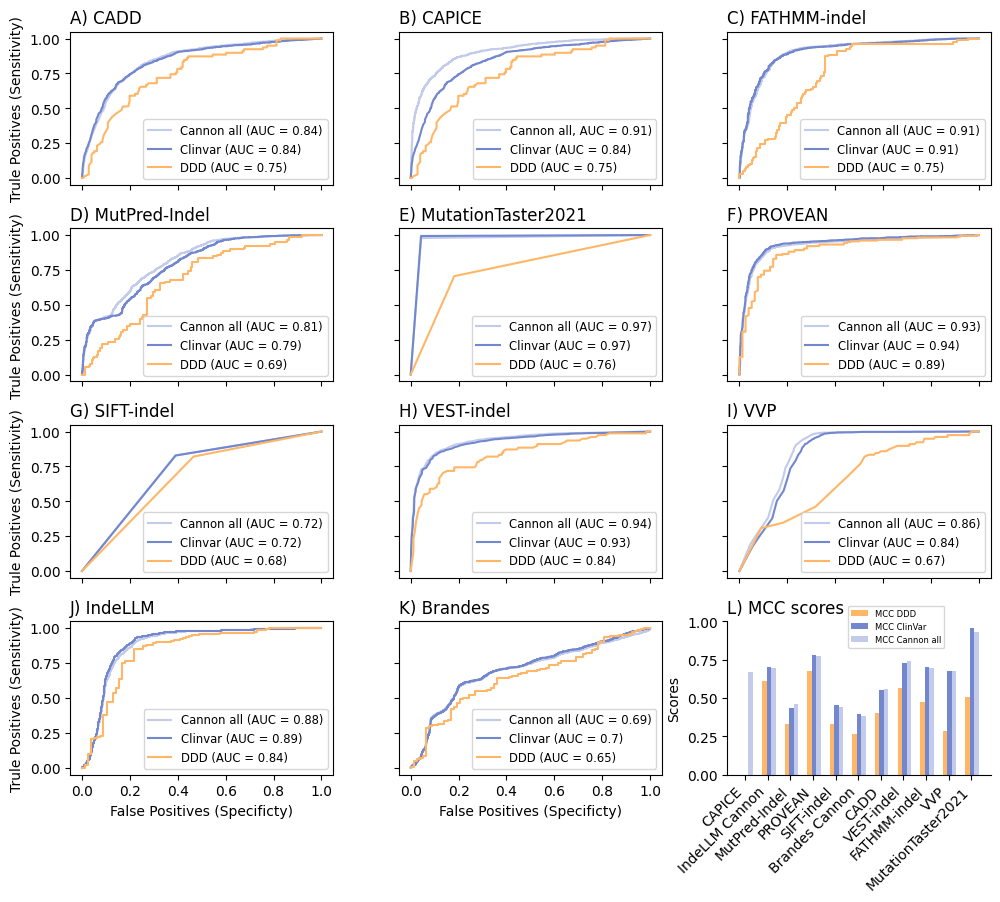

In [35]:
#Splitting Cannon et al dataset into DDD and ClinVar
Cannonetal_DDD = Cannonetal[Cannonetal['subset'] == 'Cannon et al_DDD']
Cannonetal_ClinVar = Cannonetal[Cannonetal['subset'] == 'Cannon et al_ClinVar']

#DDD split calculations
pred_CADD_DDD = Cannonetal_DDD['CADD_Cannonetal'].values
pred_CAPICE_DDD = Cannonetal_DDD['CAPICE_Cannonetal'].values
pred_FATHMM_DDD = Cannonetal_DDD['FATHMM_Cannonetal'].values
pred_MutPred_DDD = Cannonetal_DDD['MutPred_Cannonetal'].values
Cannonetal_DDD['MutationTaster2021_bin'] = [0 if x == 'Benign' else 1 for x in Cannonetal_DDD['MutationTaster2021_Cannonetal']] # Making numerical values
pred_MutT_DDD = Cannonetal_DDD['MutationTaster2021_bin'].values
pred_PROVEAN_DDD = Cannonetal_DDD['Provean_Cannonetal'].values
Cannonetal_DDD['SIFT_bin'] = [ 0 if x == 'neutral' else 1 for x in Cannonetal_DDD['SIFT_Cannonetal']] # Making numerical values
pred_SIFT_DDD = Cannonetal_DDD['SIFT_bin'].values
pred_VEST_DDD = Cannonetal_DDD['VEST_Cannonetal'].values
pred_VVP_DDD = Cannonetal_DDD['VVP_Cannonetal'].values
pred_IndeLLM_Cannonetal_DDD = Cannonetal_DDD['IndeLLM'].values
pred_Brandes_Cannonetal_DDD = Cannonetal_DDD['Brandes'].values

truelabels_Cannonetal_DDD = Cannonetal_DDD['label'].values 
truelabels_Cannonetal_DDD = 1 - truelabels_Cannonetal_DDD

fpr_CADD_DDD, tpr_CADD_DDD, thersholds_CADD_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_CADD_DDD, pos_label=0)
fpr_CAPICE_DDD, tpr_CAPICE_DDD, thersholds_CAPICE_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_CADD_DDD, pos_label=0)
fpr_FATHMM_DDD, tpr_FATHMM_DDD, thersholds_FATHMM_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_FATHMM_DDD, pos_label=0)
fpr_MutPred_DDD, tpr_MutPred_DDD, thersholds_MutPred_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_MutPred_DDD, pos_label=0)
fpr_MutT_DDD, tpr_MutT_DDD, thersholds_MutT_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_MutT_DDD, pos_label=0)
fpr_PROVEAN_DDD, tpr_PROVEAN_DDD, thersholds_PROVEAN_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_PROVEAN_DDD, pos_label=1)
fpr_SIFT_DDD, tpr_SIFT_DDD, thersholds_SIFT_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_SIFT_DDD, pos_label=0)
fpr_VEST_DDD, tpr_VEST_DDD, thersholds_VEST_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_VEST_DDD, pos_label=0)
fpr_VVP_DDD, tpr_VVP_DDD, thersholds_VVP_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_VVP_DDD, pos_label=0)
fpr_IndeLLM_Cannon_DDD, tpr_IndeLLM_Cannon_DDD, thersholds_IndeLLM_Cannon_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_IndeLLM_Cannonetal_DDD, pos_label=1)
fpr_Brandes_Cannon_DDD, tpr_Brandes_Cannon_DDD, thersholds_Brandes_Cannon_DDD = metrics.roc_curve(truelabels_Cannonetal_DDD, pred_Brandes_Cannonetal_DDD, pos_label=1)

#ClinVar split calculations
pred_CADD_ClinVar = Cannonetal_ClinVar['CADD_Cannonetal'].values
pred_CAPICE_ClinVar = Cannonetal_ClinVar['CAPICE_Cannonetal'].values
pred_FATHMM_ClinVar = Cannonetal_ClinVar['FATHMM_Cannonetal'].values
pred_MutPred_ClinVar = Cannonetal_ClinVar['MutPred_Cannonetal'].values
Cannonetal_ClinVar['MutationTaster2021_bin'] = [0 if x == 'Benign' else 1 for x in Cannonetal_ClinVar['MutationTaster2021_Cannonetal']] # Making numerical values
pred_MutT_ClinVar = Cannonetal_ClinVar['MutationTaster2021_bin'].values
pred_PROVEAN_ClinVar = Cannonetal_ClinVar['Provean_Cannonetal'].values
Cannonetal_ClinVar['SIFT_bin'] = [ 0 if x == 'neutral' else 1 for x in Cannonetal_ClinVar['SIFT_Cannonetal']] # Making numerical values
pred_SIFT_ClinVar = Cannonetal_ClinVar['SIFT_bin'].values
pred_VEST_ClinVar = Cannonetal_ClinVar['VEST_Cannonetal'].values
pred_VVP_ClinVar = Cannonetal_ClinVar['VVP_Cannonetal'].values
pred_IndeLLM_Cannonetal_ClinVar = Cannonetal_ClinVar['IndeLLM'].values
pred_Brandes_Cannonetal_ClinVar = Cannonetal_ClinVar['Brandes'].values

truelabels_Cannonetal_ClinVar = Cannonetal_ClinVar['label'].values 
truelabels_Cannonetal_ClinVar = 1 - truelabels_Cannonetal_ClinVar

fpr_CADD_ClinVar, tpr_CADD_ClinVar, thersholds_CADD_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_CADD_ClinVar, pos_label=0)
fpr_CAPICE_ClinVar, tpr_CAPICE_ClinVar, thersholds_CAPICE_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_CADD_ClinVar, pos_label=0)
fpr_FATHMM_ClinVar, tpr_FATHMM_ClinVar, thersholds_FATHMM_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_FATHMM_ClinVar, pos_label=0)
fpr_MutPred_ClinVar, tpr_MutPred_ClinVar, thersholds_MutPred_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_MutPred_ClinVar, pos_label=0)
fpr_MutT_ClinVar, tpr_MutT_ClinVar, thersholds_MutT_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_MutT_ClinVar, pos_label=0)
fpr_PROVEAN_ClinVar, tpr_PROVEAN_ClinVar, thersholds_PROVEAN_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_PROVEAN_ClinVar, pos_label=1)
fpr_SIFT_ClinVar, tpr_SIFT_ClinVar, thersholds_SIFT_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_SIFT_ClinVar, pos_label=0)
fpr_VEST_ClinVar, tpr_VEST_ClinVar, thersholds_VEST_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_VEST_ClinVar, pos_label=0)
fpr_VVP_ClinVar, tpr_VVP_ClinVar, thersholds_VVP_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_VVP_ClinVar, pos_label=0)
fpr_IndeLLM_Cannon_ClinVar, tpr_IndeLLM_Cannon_ClinVar, thersholds_IndeLLM_Cannon_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_IndeLLM_Cannonetal_ClinVar, pos_label=1)
fpr_Brandes_Cannon_ClinVar, tpr_Brandes_Cannon_ClinVar, thersholds_Brandes_Cannon_ClinVar = metrics.roc_curve(truelabels_Cannonetal_ClinVar, pred_Brandes_Cannonetal_ClinVar, pos_label=1)

methods_DDD = ['IndeLLM Cannon DDD', 'MutationTaster2021 DDD', 'PROVEAN DDD', 'VEST-indel DDD', 'FATHMM-indel DDD', 'VVP DDD', 'CAPICE DDD', 'CADD DDD', 'MutPred-Indel DDD', 'SIFT-indel DDD', 'Brandes Cannon DDD']
methods_ClinVar = ['IndeLLM Cannon ClinVar', 'MutationTaster2021 ClinVar', 'PROVEAN ClinVar', 'VEST-indel ClinVar', 'FATHMM-indel ClinVar', 'VVP ClinVar', 'CAPICE ClinVar', 'CADD ClinVar', 'MutPred-Indel ClinVar', 'SIFT-indel ClinVar', 'Brandes Cannon ClinVar']
metrics_df_filtered_DDD = metrics_df.loc[methods_DDD, :]
metrics_df_filtered_ClinVar = metrics_df.loc[methods_ClinVar, :]
metrics_df_filtered_DDD['Base Name'] = metrics_df_filtered_DDD.index.str.replace(' DDD', '')
metrics_df_filtered_ClinVar['Base Name'] = metrics_df_filtered_ClinVar.index.str.replace(' ClinVar', '')
metrics_df_filtered_DDD.set_index('Base Name', inplace=True)
metrics_df_filtered_ClinVar.set_index('Base Name', inplace=True)

metrics_df_filtered_DDDvsClinVar = metrics_df_filtered_DDD.copy()
metrics_df_filtered_DDDvsClinVar['MCC dif'] = abs(metrics_df_filtered_DDD['MCC'].values - metrics_df_filtered_ClinVar['MCC'].values)
metrics_df_filtered_DDDvsClinVar = metrics_df_filtered_DDDvsClinVar.sort_values(by='MCC dif', ascending=True)
metrics_df_filtered_DDD = metrics_df_filtered_DDD.loc[metrics_df_filtered_DDDvsClinVar.index]
metrics_df_filtered_ClinVar = metrics_df_filtered_ClinVar.loc[metrics_df_filtered_DDDvsClinVar.index]
metrics_df_filtered_cannon = metrics_df_filtered_cannon.loc[metrics_df_filtered_DDDvsClinVar.index]

n_methods = len(methods_DDD)
bar_width = 0.2
r1 = np.arange(n_methods)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

f, axes = plt.subplots(4,3)
f.set_figheight(8)
f.set_figwidth(10)
f.tight_layout(pad=1)

axes[0,0].plot(fpr_CADD, tpr_CADD, label = "Cannon all (AUC = "+str(round(metrics_df_filtered_cannon.loc['CADD', 'AUC'], 2))+")", color = "#C2CBEA")
axes[0,0].plot(fpr_CADD_ClinVar, tpr_CADD_ClinVar, label = "Clinvar (AUC = "+str(round(metrics_df_filtered_ClinVar.loc['CADD', 'AUC'], 2))+")", color = "#7287ce")
axes[0,0].plot(fpr_CADD_DDD, tpr_CADD_DDD, label = "DDD (AUC = "+str(round(metrics_df_filtered_DDD.loc['CADD', 'AUC'], 2))+")", color = "#ffb666")
axes[0,0].set_title('A) CADD', loc = 'left')
axes[0,0].set_ylabel('Trule Positives (Sensitivity)')
axes[0,0].set_xlabel('')
axes[0,0].set_xticklabels('')
axes[0,0].legend(fontsize='small')

axes[0,1].plot(fpr_CAPICE, tpr_CAPICE, label = "Cannon all, AUC = "+str(round(metrics_df_filtered_cannon.loc['CAPICE', 'AUC'],2))+")", color = "#C2CBEA")
axes[0,1].plot(fpr_CAPICE_ClinVar, tpr_CAPICE_ClinVar, label = "Clinvar (AUC = "+str(round(metrics_df_filtered_ClinVar.loc['CAPICE', 'AUC'],2))+")", color = "#7287ce")
axes[0,1].plot(fpr_CAPICE_DDD, tpr_CAPICE_DDD, label = "DDD (AUC = "+str(round(metrics_df_filtered_DDD.loc['CAPICE', 'AUC'],2))+")", color = "#ffb666")
axes[0,1].set_title('B) CAPICE', loc = 'left')
axes[0,1].set_ylabel('')
axes[0,1].set_xlabel('')
axes[0,1].set_yticklabels('')
axes[0,1].set_xticklabels('')
axes[0,1].legend(fontsize='small')

axes[0,2].plot(fpr_FATHMM, tpr_FATHMM, label = "Cannon all (AUC = "+str(round(metrics_df_filtered_cannon.loc['FATHMM-indel', 'AUC'],2))+")", color = "#C2CBEA")
axes[0,2].plot(fpr_FATHMM_ClinVar, tpr_FATHMM_ClinVar, label = "Clinvar (AUC = "+str(round(metrics_df_filtered_ClinVar.loc['FATHMM-indel', 'AUC'],2))+")", color = "#7287ce")
axes[0,2].plot(fpr_FATHMM_DDD, tpr_FATHMM_DDD, label = "DDD (AUC = "+str(round(metrics_df_filtered_DDD.loc['FATHMM-indel', 'AUC'],2))+")", color = "#ffb666")
axes[0,2].set_title('C) FATHMM-indel', loc = 'left')
axes[0,2].set_ylabel('')
axes[0,2].set_xlabel('')
axes[0,2].set_yticklabels('')
axes[0,2].set_xticklabels('')
axes[0,2].legend(fontsize='small')

axes[1,0].plot(fpr_MutPred, tpr_MutPred, label = "Cannon all (AUC = "+str(round(metrics_df_filtered_cannon.loc['MutPred-Indel', 'AUC'],2))+")", color = "#C2CBEA")
axes[1,0].plot(fpr_MutPred_ClinVar, tpr_MutPred_ClinVar, label = "Clinvar (AUC = "+str(round(metrics_df_filtered_ClinVar.loc['MutPred-Indel', 'AUC'],2))+")", color = "#7287ce")
axes[1,0].plot(fpr_MutPred_DDD, tpr_MutPred_DDD, label = "DDD (AUC = "+str(round(metrics_df_filtered_DDD.loc['MutPred-Indel', 'AUC'],2))+")", color = "#ffb666")
axes[1,0].set_title('D) MutPred-Indel', loc = 'left')
axes[1,0].set_ylabel('Trule Positives (Sensitivity)')
axes[1,0].set_xlabel('')
axes[1,0].set_xticklabels('')
axes[1,0].legend(fontsize='small')

axes[1,1].plot(fpr_MutT, tpr_MutT, label = "Cannon all (AUC = "+str(round(metrics_df_filtered_cannon.loc['MutationTaster2021', 'AUC'],2))+")", color = "#C2CBEA")
axes[1,1].plot(fpr_MutT_ClinVar, tpr_MutT_ClinVar, label = "Clinvar (AUC = "+str(round(metrics_df_filtered_ClinVar.loc['MutationTaster2021', 'AUC'],2))+")", color = "#7287ce")
axes[1,1].plot(fpr_MutT_DDD, tpr_MutT_DDD, label = "DDD (AUC = "+str(round(metrics_df_filtered_DDD.loc['MutationTaster2021', 'AUC'],2))+")", color = "#ffb666")
axes[1,1].set_title('E) MutationTaster2021', loc = 'left')
axes[1,1].set_ylabel('')
axes[1,1].set_xlabel('')
axes[1,1].set_yticklabels('')
axes[1,1].set_xticklabels('')
axes[1,1].legend(fontsize='small')

axes[1,2].plot(fpr_PROVEAN, tpr_PROVEAN, label = "Cannon all (AUC = "+str(round(metrics_df_filtered_cannon.loc['PROVEAN', 'AUC'],2))+")", color = "#C2CBEA")
axes[1,2].plot(fpr_PROVEAN_ClinVar, tpr_PROVEAN_ClinVar, label = "Clinvar (AUC = "+str(round(metrics_df_filtered_ClinVar.loc['PROVEAN', 'AUC'],2))+")", color = "#7287ce")
axes[1,2].plot(fpr_PROVEAN_DDD, tpr_PROVEAN_DDD, label = "DDD (AUC = "+str(round(metrics_df_filtered_DDD.loc['PROVEAN', 'AUC'],2))+")", color = "#ffb666")
axes[1,2].set_title('F) PROVEAN', loc = 'left')
axes[1,2].set_ylabel('')
axes[1,2].set_xlabel('')
axes[1,2].set_yticklabels('')
axes[1,2].set_xticklabels('')
axes[1,2].legend(fontsize='small')

axes[2,0].plot(fpr_SIFT, tpr_SIFT, label = "Cannon all (AUC = "+str(round(metrics_df_filtered_cannon.loc['SIFT-indel', 'AUC'],2))+")", color = "#C2CBEA")
axes[2,0].plot(fpr_SIFT_ClinVar, tpr_SIFT_ClinVar, label = "Clinvar (AUC = "+str(round(metrics_df_filtered_ClinVar.loc['SIFT-indel', 'AUC'],2))+")", color = "#7287ce")
axes[2,0].plot(fpr_SIFT_DDD, tpr_SIFT_DDD, label = "DDD (AUC = "+str(round(metrics_df_filtered_DDD.loc['SIFT-indel', 'AUC'],2))+")", color = "#ffb666")
axes[2,0].set_title('G) SIFT-indel', loc = 'left')
axes[2,0].set_ylabel('Trule Positives (Sensitivity)')
axes[2,0].set_xlabel('')
axes[2,0].set_xticklabels('')
axes[2,0].legend(fontsize='small')

axes[2,1].plot(fpr_VEST, tpr_VEST, label = "Cannon all (AUC = "+str(round(metrics_df_filtered_cannon.loc['VEST-indel', 'AUC'],2))+")", color = "#C2CBEA")
axes[2,1].plot(fpr_VEST_ClinVar, tpr_VEST_ClinVar, label = "Clinvar (AUC = "+str(round(metrics_df_filtered_ClinVar.loc['VEST-indel', 'AUC'],2))+")", color = "#7287ce")
axes[2,1].plot(fpr_VEST_DDD, tpr_VEST_DDD, label = "DDD (AUC = "+str(round(metrics_df_filtered_DDD.loc['VEST-indel', 'AUC'],2))+")", color = "#ffb666")
axes[2,1].set_title('H) VEST-indel', loc = 'left')
axes[2,1].set_ylabel('')
axes[2,1].set_xlabel('')
axes[2,1].set_yticklabels('')
axes[2,1].set_xticklabels('')
axes[2,1].legend(fontsize='small')

axes[2,2].plot(fpr_VVP, tpr_VVP, label = "Cannon all (AUC = "+str(round(metrics_df_filtered_cannon.loc['VVP', 'AUC'],2))+")", color = "#C2CBEA")
axes[2,2].plot(fpr_VVP_ClinVar, tpr_VVP_ClinVar, label = "Clinvar (AUC = "+str(round(metrics_df_filtered_ClinVar.loc['VVP', 'AUC'],2))+")", color = "#7287ce")
axes[2,2].plot(fpr_VVP_DDD, tpr_VVP_DDD, label = "DDD (AUC = "+str(round(metrics_df_filtered_DDD.loc['VVP', 'AUC'],2))+")", color = "#ffb666")
axes[2,2].set_title('I) VVP', loc = 'left')
axes[2,2].set_ylabel('')
axes[2,2].set_xlabel('')
axes[2,2].set_yticklabels('')
axes[2,2].set_xticklabels('')
axes[2,2].legend(fontsize='small')

axes[3,0].plot(fpr_IndeLLM_Cannon, tpr_IndeLLM_Cannon, label = "Cannon all (AUC = "+str(round(metrics_df_filtered_cannon.loc['IndeLLM Cannon', 'AUC'],2))+")", color = "#C2CBEA")
axes[3,0].plot(fpr_IndeLLM_Cannon_ClinVar, tpr_IndeLLM_Cannon_ClinVar, label = "Clinvar (AUC = "+str(round(metrics_df_filtered_ClinVar.loc['IndeLLM Cannon', 'AUC'],2))+")", color = "#7287ce")
axes[3,0].plot(fpr_IndeLLM_Cannon_DDD, tpr_IndeLLM_Cannon_DDD, label = "DDD (AUC = "+str(round(metrics_df_filtered_DDD.loc['IndeLLM Cannon', 'AUC'],2))+")", color = "#ffb666")
axes[3,0].set_title('J) IndeLLM', loc = 'left')
axes[3,0].set_ylabel('Trule Positives (Sensitivity)')
axes[3,0].set_xlabel('False Positives (Specificty)')
axes[3,0].legend(fontsize='small')

axes[3,1].plot(fpr_Brandes_Cannon, tpr_Brandes_Cannon, label = "Cannon all (AUC = "+str(round(metrics_df_filtered_cannon.loc['Brandes Cannon', 'AUC'],2))+")", color = "#C2CBEA")
axes[3,1].plot(fpr_Brandes_Cannon_ClinVar, tpr_Brandes_Cannon_ClinVar, label = "Clinvar (AUC = "+str(round(metrics_df_filtered_ClinVar.loc['Brandes Cannon', 'AUC'],2))+")", color = "#7287ce")
axes[3,1].plot(fpr_Brandes_Cannon_DDD, tpr_Brandes_Cannon_DDD, label = "DDD (AUC = "+str(round(metrics_df_filtered_DDD.loc['Brandes Cannon', 'AUC'],2))+")", color = "#ffb666")
axes[3,1].set_title('K) Brandes', loc = 'left')
axes[3,1].set_ylabel('')
axes[3,1].set_xlabel('False Positives (Specificty)')
axes[3,1].set_yticklabels('')
axes[3,1].legend(fontsize='small')

axes[3,2].bar(r1, metrics_df_filtered_DDD['MCC'], width=bar_width, label='MCC DDD', color = '#ffb666')
axes[3,2].bar(r2, metrics_df_filtered_ClinVar['MCC'], width=bar_width, label='MCC ClinVar', color = '#7287ce')
axes[3,2].bar(r3, metrics_df_filtered_cannon['MCC'], width=bar_width, label='MCC Cannon all', color = '#C2CBEA')
axes[3,2].set_title('L) MCC scores', loc = 'left')
axes[3,2].set_xlabel('')
axes[3,2].set_ylabel('Scores')
axes[3,2].set_xticks([r + (0.8*bar_width) for r in range(n_methods)])
axes[3,2].set_xticklabels(metrics_df_filtered_DDDvsClinVar.index, rotation = 45, ha='right')
axes[3,2].spines['top'].set_visible(False)
axes[3,2].spines['right'].set_visible(False)
axes[3,2].legend(fontsize = 6 , bbox_to_anchor=(0.84, 0.8))

# Plotting Figure 3

,AUC,F1,MCC
Base Name,,,
MutPred-Indel,0.869228,0.808030,0.570972
IndeLLM,0.857987,0.834158,0.623841
Provean,0.906764,0.877370,0.728372
Model 4 mean,0.938611,0.878661,0.773073


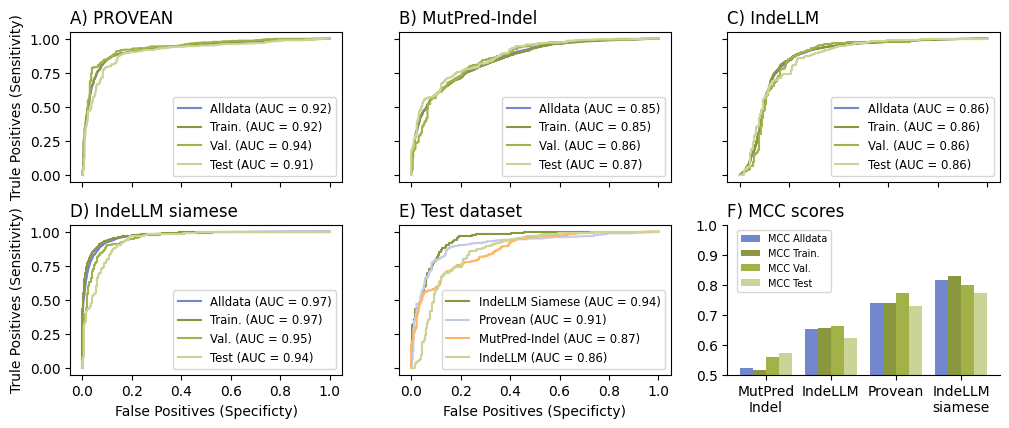

In [36]:
#Adding ESM2_650M IndeLLM scores to test, validation and train datasets so that we can see the difference in datasets
train['dif_IndeLLM'] = train.apply(lambda row: scoresESM2_650M[scoresESM2_650M['id'] == row['id']]['dif_IndeLLM'].values[0], axis=1)
test['dif_IndeLLM'] = test.apply(lambda row: scoresESM2_650M[scoresESM2_650M['id'] == row['id']]['dif_IndeLLM'].values[0], axis=1)
val['dif_IndeLLM'] = val.apply(lambda row: scoresESM2_650M[scoresESM2_650M['id'] == row['id']]['dif_IndeLLM'].values[0], axis=1)
alldata_siamesedata = pd.concat([train, val, test], axis=0)

# IndeLLM scores on smaller datasets
pred_ESM2650M_IndeLLM_train = train['dif_IndeLLM'].values
pred_ESM2650M_IndeLLM_val = val['dif_IndeLLM'].values
pred_ESM2650M_IndeLLM_test = test['dif_IndeLLM'].values
pred_ESM2650M_IndeLLM_alldata = alldata_siamesedata['dif_IndeLLM'].values
pred_siamese_m4_train = siamese_m4_train['mean'].values
pred_siamese_m4_val = siamese_m4_val['mean'].values
pred_siamese_m4_test = siamese_m4_test['mean'].values
pred_siamese_m4_alldata = siamese_m4_alldata['mean'].values

# Other predictors on full datasets and splits
pred_Provean_alldata = alldata_siamesedata['Provean'].values
pred_Provean_train = train['Provean'].values
pred_Provean_val = val['Provean'].values
pred_Provean_test = test['Provean'].values
pred_MutPred_alldata = alldata_siamesedata['MutPred-Indel'].values
pred_MutPred_train = train['MutPred-Indel'].values
pred_MutPred_val = val['MutPred-Indel'].values
pred_MutPred_test = test['MutPred-Indel'].values

#Extracting the true labels for each dataset split
truelabels_train = train['label'].values
truelabels_val = val['label'].values
truelabels_test = test['label'].values
truelabels_siamesedata = alldata_siamesedata['label'].values

fpr_ESM2650M_train, tpr_ESM2650M_train, thersholds_ESM2650M_train = metrics.roc_curve(truelabels_train, pred_ESM2650M_IndeLLM_train, pos_label=0)
fpr_ESM2650M_val, tpr_ESM2650M_val, thersholds_ESM2650M_val = metrics.roc_curve(truelabels_val, pred_ESM2650M_IndeLLM_val, pos_label=0)
fpr_ESM2650M_test, tpr_ESM2650M_test, thersholds_ESM2650M_test = metrics.roc_curve(truelabels_test, pred_ESM2650M_IndeLLM_test, pos_label=0)
fpr_ESM2650M_alldata, tpr_ESM2650M_alldata, thersholds_ESM2650M_alldata = metrics.roc_curve(truelabels_siamesedata, pred_ESM2650M_IndeLLM_alldata, pos_label=0)
fpr_siamese_m4_train, tpr_siamese_m4_train, thersholds_siamese_m4_train = metrics.roc_curve(truelabels_train, pred_siamese_m4_train, pos_label=1)
fpr_siamese_m4_val, tpr_siamese_m4_val, thersholds_siamese_m4_val = metrics.roc_curve(truelabels_val, pred_siamese_m4_val, pos_label=1)
fpr_siamese_m4_test, tpr_siamese_m4_test, thersholds_siamese_m4_test = metrics.roc_curve(truelabels_test, pred_siamese_m4_test, pos_label=1)
fpr_siamese_m4_alldata, tpr_siamese_m4_alldata, thersholds_siamese_m4_alldata = metrics.roc_curve(truelabels_siamesedata, pred_siamese_m4_alldata, pos_label=1)
fpr_Provean_alldata, tpr_Provean_alldata, thersholds_Provean_alldata = metrics.roc_curve(truelabels_siamesedata, pred_Provean_alldata, pos_label=0)
fpr_Provean_train, tpr_Provean_train, thersholds_Provean_train = metrics.roc_curve(truelabels_train, pred_Provean_train, pos_label=0)
fpr_Provean_val, tpr_Provean_val, thersholds_Provean_val = metrics.roc_curve(truelabels_val, pred_Provean_val, pos_label=0)
fpr_Provean_test, tpr_Provean_test, thersholds_Provean_test = metrics.roc_curve(truelabels_test, pred_Provean_test, pos_label=0)
fpr_MutPred_alldata, tpr_MutPred_alldata, thersholds_MutPred_alldata = metrics.roc_curve(truelabels_siamesedata, pred_MutPred_alldata, pos_label=1)
fpr_MutPred_train, tpr_MutPred_train, thersholds_MutPred_train = metrics.roc_curve(truelabels_train, pred_MutPred_train, pos_label=1)
fpr_MutPred_val, tpr_MutPred_val, thersholds_MutPred_val = metrics.roc_curve(truelabels_val, pred_MutPred_val, pos_label=1)
fpr_MutPred_test, tpr_MutPred_test, thersholds_MutPred_test = metrics.roc_curve(truelabels_test, pred_MutPred_test, pos_label=1)

siamese_train = ['IndeLLM train', 'Provean train', 'MutPred-Indel train', 'Model 4 mean train']
siamese_val = ['IndeLLM val', 'Provean val', 'MutPred-Indel val', 'Model 4 mean val']
siamese_test = ['IndeLLM test', 'Provean test', 'MutPred-Indel test', 'Model 4 mean test']
siamese_alldata = ['IndeLLM alldata', 'Provean alldata', 'MutPred-Indel alldata', 'Model 4 mean alldata']

metrics_df_filtered_train = metrics_df.loc[siamese_train, :]
metrics_df_filtered_val = metrics_df.loc[siamese_val, :]
metrics_df_filtered_test = metrics_df.loc[siamese_test, :]
metrics_df_filtered_alldata = metrics_df.loc[siamese_alldata, :]

metrics_df_filtered_train['Base Name'] = metrics_df_filtered_train.index.str.replace(' train', '')
metrics_df_filtered_val['Base Name'] = metrics_df_filtered_val.index.str.replace(' val', '')
metrics_df_filtered_test['Base Name'] = metrics_df_filtered_test.index.str.replace(' test', '')
metrics_df_filtered_alldata['Base Name'] = metrics_df_filtered_alldata.index.str.replace(' alldata', '')

metrics_df_filtered_train.set_index('Base Name', inplace=True)
metrics_df_filtered_val.set_index('Base Name', inplace=True)
metrics_df_filtered_test.set_index('Base Name', inplace=True)
metrics_df_filtered_alldata.set_index('Base Name', inplace=True)

metrics_df_filtered_allvstest = metrics_df_filtered_test.copy()
metrics_df_filtered_allvstest = metrics_df_filtered_allvstest.sort_values(by='MCC', ascending=True)
metrics_df_filtered_train = metrics_df_filtered_train.loc[metrics_df_filtered_allvstest.index]
metrics_df_filtered_val = metrics_df_filtered_val.loc[metrics_df_filtered_allvstest.index]
metrics_df_filtered_test = metrics_df_filtered_test.loc[metrics_df_filtered_allvstest.index]
metrics_df_filtered_alldata = metrics_df_filtered_alldata.loc[metrics_df_filtered_allvstest.index]

n_methods = len(siamese_alldata)
bar_width = 0.2
r1 = np.arange(n_methods)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]


f, axes = plt.subplots(2,3)
f.set_figheight(4)
f.set_figwidth(10)
f.tight_layout(pad=1)

axes[0,0].plot(fpr_Provean_alldata, tpr_Provean_alldata, label = "Alldata (AUC = "+str(round(metrics_df_filtered_alldata.loc['Provean', 'AUC'],2))+")", color = "#7287ce")
axes[0,0].plot(fpr_Provean_train, tpr_Provean_train, label = "Train. (AUC = "+str(round(metrics_df_filtered_train.loc['Provean', 'AUC'],2))+")", color = "#8a973e")
axes[0,0].plot(fpr_Provean_val, tpr_Provean_val, label = "Val. (AUC = "+str(round(metrics_df_filtered_val.loc['Provean', 'AUC'],2))+")", color = "#A2b148")
axes[0,0].plot(fpr_Provean_test, tpr_Provean_test, label = "Test (AUC = "+str(round(metrics_df_filtered_test.loc['Provean', 'AUC'],2))+")", color = "#CBD496")
axes[0,0].set_title('A) PROVEAN', loc = 'left')
axes[0,0].set_ylabel('Trule Positives (Sensitivity)')
axes[0,0].set_xlabel('')
axes[0,0].set_xticklabels('')
axes[0,0].legend(fontsize='small')

axes[0,1].plot(fpr_MutPred_alldata, tpr_MutPred_alldata, label = "Alldata (AUC = "+str(round(metrics_df_filtered_alldata.loc['MutPred-Indel', 'AUC'],2))+")", color = "#7287ce")
axes[0,1].plot(fpr_MutPred_train, tpr_MutPred_train, label = "Train. (AUC = "+str(round(metrics_df_filtered_train.loc['MutPred-Indel', 'AUC'],2))+")", color = "#8a973e")
axes[0,1].plot(fpr_MutPred_val, tpr_MutPred_val, label = "Val. (AUC = "+str(round(metrics_df_filtered_val.loc['MutPred-Indel', 'AUC'],2))+")", color = "#A2b148")
axes[0,1].plot(fpr_MutPred_test, tpr_MutPred_test, label = "Test (AUC = "+str(round(metrics_df_filtered_test.loc['MutPred-Indel', 'AUC'],2))+")", color = "#CBD496")
axes[0,1].set_title('B) MutPred-Indel', loc = 'left')
axes[0,1].set_ylabel('')
axes[0,1].set_xlabel('')
axes[0,1].set_yticklabels('')
axes[0,1].set_xticklabels('')
axes[0,1].legend(fontsize='small')

axes[0,2].plot(fpr_ESM2650M_IndeLLM, tpr_ESM2650M_IndeLLM, label = "Alldata (AUC = "+str(round(metrics_df_filtered_alldata.loc['IndeLLM', 'AUC'],2))+")", color = "#7287ce")
axes[0,2].plot(fpr_ESM2650M_train, tpr_ESM2650M_train, label = "Train. (AUC = "+str(round(metrics_df_filtered_train.loc['IndeLLM', 'AUC'],2))+")", color = "#8a973e")
axes[0,2].plot(fpr_ESM2650M_val, tpr_ESM2650M_val, label = "Val. (AUC = "+str(round(metrics_df_filtered_val.loc['IndeLLM', 'AUC'],2))+")", color = "#A2b148")
axes[0,2].plot(fpr_ESM2650M_test, tpr_ESM2650M_test, label = "Test (AUC = "+str(round(metrics_df_filtered_test.loc['IndeLLM', 'AUC'],2))+")", color = "#CBD496")
axes[0,2].set_title('C) IndeLLM', loc = 'left')
axes[0,2].set_ylabel('')
axes[0,2].set_xlabel('')
axes[0,2].set_yticklabels('')
axes[0,2].set_xticklabels('')
axes[0,2].legend(fontsize='small')

axes[1,0].plot(fpr_siamese_m4_alldata, tpr_siamese_m4_alldata, label = "Alldata (AUC = "+str(round(metrics_df_filtered_alldata.loc['Model 4 mean', 'AUC'],2))+")", color = "#7287ce")
axes[1,0].plot(fpr_siamese_m4_train, tpr_siamese_m4_train, label = "Train. (AUC = "+str(round(metrics_df_filtered_train.loc['Model 4 mean', 'AUC'],2))+")", color = "#8a973e")
axes[1,0].plot(fpr_siamese_m4_val, tpr_siamese_m4_val, label = "Val. (AUC = "+str(round(metrics_df_filtered_val.loc['Model 4 mean', 'AUC'],2))+")", color = "#A2b148")
axes[1,0].plot(fpr_siamese_m4_test, tpr_siamese_m4_test, label = "Test (AUC = "+str(round(metrics_df_filtered_test.loc['Model 4 mean', 'AUC'],2))+")", color = "#CBD496")
axes[1,0].set_title('D) IndeLLM siamese', loc = 'left')
axes[1,0].set_ylabel('Trule Positives (Sensitivity)')
axes[1,0].set_xlabel('False Positives (Specificty)')
axes[1,0].legend(fontsize='small')

axes[1,1].plot(fpr_siamese_m4_test, tpr_siamese_m4_test, label = "IndeLLM Siamese (AUC = "+str(round(metrics_df_filtered_test.loc['Model 4 mean', 'AUC'],2))+")", color = "#8a973e")
axes[1,1].plot(fpr_Provean_test, tpr_Provean_test, label = "Provean (AUC = "+str(round(metrics_df_filtered_test.loc['Provean', 'AUC'],2))+")", color = "#C2CBEA")
axes[1,1].plot(fpr_MutPred_test, tpr_MutPred_test, label = "MutPred-Indel (AUC = "+str(round(metrics_df_filtered_test.loc['MutPred-Indel', 'AUC'],2))+")", color = "#ffb666")
axes[1,1].plot(fpr_ESM2650M_test, tpr_ESM2650M_test, label = "IndeLLM (AUC = "+str(round(metrics_df_filtered_test.loc['IndeLLM', 'AUC'],2))+")", color = "#CBD496")
axes[1,1].set_title('E) Test dataset', loc = 'left')
axes[1,1].set_ylabel('')
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('False Positives (Specificty)')
axes[1,1].legend(fontsize='small')

axes[1,2].bar(r1, metrics_df_filtered_alldata['MCC'], width=bar_width, label='MCC Alldata', color = '#7287ce')
axes[1,2].bar(r2, metrics_df_filtered_train['MCC'], width=bar_width, label='MCC Train.', color = '#8a973e')
axes[1,2].bar(r3, metrics_df_filtered_val['MCC'], width=bar_width, label='MCC Val.', color = '#A2b148')
axes[1,2].bar(r4, metrics_df_filtered_test['MCC'], width=bar_width, label='MCC Test', color = '#CBD496')
axes[1,2].set_title('F) MCC scores', loc = 'left')
axes[1,2].set_xlabel('')
axes[1,2].set_ylabel('')
axes[1,2].set_ylim([0.5, 1])
axes[1,2].set_xticks([r + (1.5*bar_width) for r in range(n_methods)])
axes[1,2].set_xticklabels(['MutPred\nIndel', 'IndeLLM', 'Provean', 'IndeLLM\nsiamese'])
axes[1,2].spines[['top', 'right']].set_visible(False)
axes[1,2].legend(fontsize = 7 , bbox_to_anchor=(0.4, 1))

metrics_df_filtered_allvstest

# Plotting Figure 4

First we split the dataset by indel type (insertion and deletions).
Second we recalcualte the false and true positives to generate confusions matrixes per indel type and scoring approach. 

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_16374/3667233253.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 0.95])


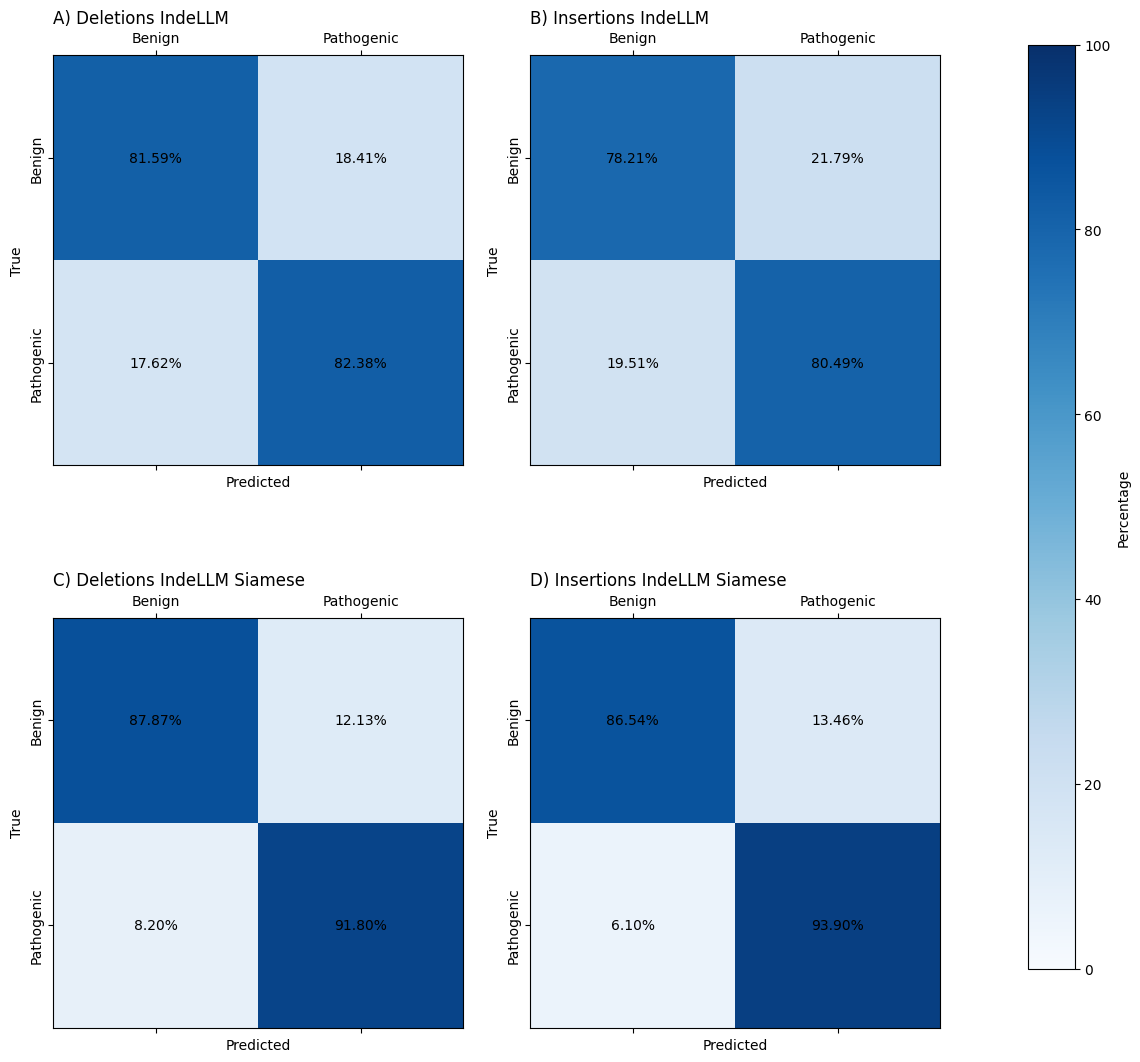

In [37]:
test_ins = test[test['indel_type'] == 'insertion']
test_del = test[test['indel_type'] == 'deletion']
siamese_m4_mean_test_ins = siamese_m4_test[siamese_m4_test['id'].isin(test_ins['id'])]
siamese_m4_mean_test_del = siamese_m4_test[siamese_m4_test['id'].isin(test_del['id'])]

pred_test_ins_IndeLLM = test_ins['dif_IndeLLM'].values
pred_test_del_IndeLLM = test_del['dif_IndeLLM'].values
pred_test_ins_m4_mean = siamese_m4_mean_test_ins['mean'].values
pred_test_del_m4_mean = siamese_m4_mean_test_del['mean'].values

truelabels_test_ins = test_ins['label'].values
truelabels_test_del = test_del['label'].values

fpr_test_ins_IndeLLM, tpr_test_ins_IndeLLM, thersholds_test_ins_IndeLLM = metrics.roc_curve(truelabels_test_ins, pred_test_ins_IndeLLM, pos_label=0)
fpr_test_del_IndeLLM, tpr_test_del_IndeLLM, thersholds_test_del_IndeLLM = metrics.roc_curve(truelabels_test_del, pred_test_del_IndeLLM, pos_label=0)
fpr_test_ins_m4_mean, tpr_test_ins_m4_mean, thersholds_test_ins_m4_mean = metrics.roc_curve(truelabels_test_ins, pred_test_ins_m4_mean, pos_label=1)
fpr_test_del_m4_mean, tpr_test_del_m4_mean, thersholds_test_del_m4_mean = metrics.roc_curve(truelabels_test_del, pred_test_del_m4_mean, pos_label=1)

tresh_test_ins_IndeLLM = thersholds_test_ins_IndeLLM[np.argmax(tpr_test_ins_IndeLLM - fpr_test_ins_IndeLLM)]
tresh_test_del_IndeLLM = thersholds_test_del_IndeLLM[np.argmax(tpr_test_del_IndeLLM - fpr_test_del_IndeLLM)]
tresh_test_ins_m4_mean = thersholds_test_ins_m4_mean[np.argmax(tpr_test_ins_m4_mean - fpr_test_ins_m4_mean)]
tresh_test_del_m4_mean = thersholds_test_del_m4_mean[np.argmax(tpr_test_del_m4_mean - fpr_test_del_m4_mean)]

pred_test_ins_IndeLLM_bin = [0 if x >= tresh_test_ins_IndeLLM else 1 for x in pred_test_ins_IndeLLM]
pred_test_del_IndeLLM_bin = [0 if x >= tresh_test_del_IndeLLM else 1 for x in pred_test_del_IndeLLM]
pred_test_ins_m4_mean_bin = [1 if x >= tresh_test_ins_m4_mean else 0 for x in pred_test_ins_m4_mean]
pred_test_del_m4_mean_bin = [1 if x >= tresh_test_del_m4_mean else 0 for x in pred_test_del_m4_mean]

confusion_test_ins_IndeLLM = confusion_matrix(truelabels_test_ins, pred_test_ins_IndeLLM_bin)
confusion_test_del_IndeLLM = confusion_matrix(truelabels_test_del, pred_test_del_IndeLLM_bin)
confusion_test_ins_m4_mean = confusion_matrix(truelabels_test_ins, pred_test_ins_m4_mean_bin)
confusion_test_del_m4_mean = confusion_matrix(truelabels_test_del, pred_test_del_m4_mean_bin)

labels = ["Pathogenic", "Benign"]
titles_test = [
    "A) Deletions IndeLLM",
    "B) Insertions IndeLLM",
    "C) Deletions IndeLLM Siamese",
    "D) Insertions IndeLLM Siamese" 
]
confusions_test = [
    confusion_test_del_IndeLLM,
    confusion_test_ins_IndeLLM,
    confusion_test_del_m4_mean,
    confusion_test_ins_m4_mean
]

# Define the percentage matrix calculation
def calculate_percentage_matrix(confusion):
    return (confusion.T / confusion.sum(axis=1)).T * 100

# Plot function for each confusion matrix
def plot_percentage_confusion_matrix(confusion, title, labels, ax):
    percentage_matrix = calculate_percentage_matrix(confusion)
    cax = ax.matshow(percentage_matrix, cmap="Blues", vmin=0, vmax=100)

    # Annotate each cell with the percentage value
    for (i, j), value in np.ndenumerate(percentage_matrix):
        ax.text(j, i, f"{value:.2f}%", ha="center", va="center", color="black")

    ax.set_xticks([1, 0])
    ax.set_xticklabels(labels)
    ax.set_yticks([1, 0])
    ax.set_yticklabels(labels, rotation = 90, va='center')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title, loc = 'left')
    
    return cax

fig_test, axes_test = plt.subplots(2, 2, figsize=(12, 12))
for ax, confusion_test, title_test in zip(axes_test.ravel(), confusions_test, titles_test):
    cax_matrix_test = plot_percentage_confusion_matrix(confusion_test, title_test, labels, ax=ax)
fig_test.colorbar(cax_matrix_test, ax=axes_test.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.05, label='Percentage')
plt.tight_layout(rect=[0, 0, 0.8, 0.95])

# Supplement Material Figure S5

We calculated the mean likelihoods of the instered amino acid by substracting the Brandes mutated score from the IndeLLM mutated score (Brandes is the sum of all likelhoods, while IndeLLM is the sum of likehoods of the non-inserted residues). The difference is the values of the inserted residues. Then we use the lenght of the indel to find the mean value of the inserted residues. 

Then we splitt insertion subset by labels (pathogenic and bening) to identify the true and false positives. 

/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_16374/2285345621.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scoresESM2_650M_ins['mean_inserted'] = (scoresESM2_650M_ins['Brandes_mut'] - scoresESM2_650M_ins['IndeLLM_mut']) / scoresESM2_650M_ins['indel_length']
/var/folders/5p/q6ym8f8d30bcrz8gjd8ks42h0000gn/T/ipykernel_16374/2285345621.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scoresESM2_650M_ins['pred_ESM2650M_IndeLLM_ins_bin'] = pred_ESM2650M_IndeLLM_ins_bin
/var/folders/5p/q6

(91, 3)

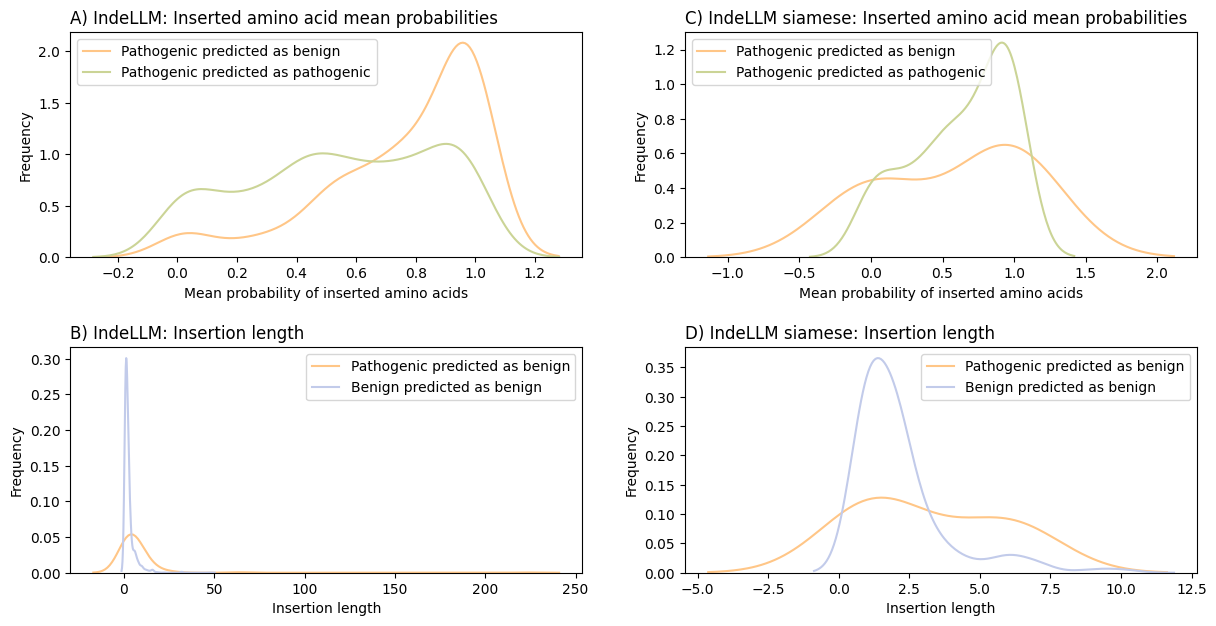

In [38]:
scoresESM2_650M_ins = scoresESM2_650M[scoresESM2_650M['indel_type'] == 'insertion']
scoresESM2_650M_del = scoresESM2_650M[scoresESM2_650M['indel_type'] == 'deletion']

pred_ESM2650M_Brandes_ins = scoresESM2_650M_ins['dif_Brandes'].values
pred_ESM2650M_IndeLLM_ins = scoresESM2_650M_ins['dif_IndeLLM'].values
pred_ESM2650M_Brandes_del = scoresESM2_650M_del['dif_Brandes'].values
pred_ESM2650M_IndeLLM_del = scoresESM2_650M_del['dif_IndeLLM'].values

truelabels_ESM2650M_ins = scoresESM2_650M_ins['label'].values
truelabels_ESM2650M_del = scoresESM2_650M_del['label'].values

fpr_ESM2650M_Brandes_ins, tpr_ESM2650M_Brandes_ins, thersholds_ESM2650M_Brandes_ins = metrics.roc_curve(truelabels_ESM2650M_ins, pred_ESM2650M_Brandes_ins, pos_label=0)
fpr_ESM2650M_IndeLLM_ins, tpr_ESM2650M_IndeLLM_ins, thersholds_ESM2650M_IndeLLM_ins = metrics.roc_curve(truelabels_ESM2650M_ins, pred_ESM2650M_IndeLLM_ins, pos_label=0)
fpr_ESM2650M_Brandes_del, tpr_ESM2650M_Brandes_del, thersholds_ESM2650M_Brandes_del = metrics.roc_curve(truelabels_ESM2650M_del, pred_ESM2650M_Brandes_del, pos_label=0)
fpr_ESM2650M_IndeLLM_del, tpr_ESM2650M_IndeLLM_del, thersholds_ESM2650M_IndeLLM_del = metrics.roc_curve(truelabels_ESM2650M_del, pred_ESM2650M_IndeLLM_del, pos_label=0)

tresh_ESM2650M_Brandes_ins = thersholds_ESM2650M_Brandes_ins[np.argmax(tpr_ESM2650M_Brandes_ins - fpr_ESM2650M_Brandes_ins)]
tresh_ESM2650M_IndeLLM_ins = thersholds_ESM2650M_IndeLLM_ins[np.argmax(tpr_ESM2650M_IndeLLM_ins - fpr_ESM2650M_IndeLLM_ins)]
tresh_ESM2650M_Brandes_del = thersholds_ESM2650M_Brandes_del[np.argmax(tpr_ESM2650M_Brandes_del - fpr_ESM2650M_Brandes_del)]
tresh_ESM2650M_IndeLLM_del = thersholds_ESM2650M_IndeLLM_del[np.argmax(tpr_ESM2650M_IndeLLM_del - fpr_ESM2650M_IndeLLM_del)]

pred_ESM2650M_Brandes_ins_bin = [0 if x >= tresh_ESM2650M_Brandes_ins else 1 for x in pred_ESM2650M_Brandes_ins]
pred_ESM2650M_IndeLLM_ins_bin = [0 if x >= tresh_ESM2650M_IndeLLM_ins else 1 for x in pred_ESM2650M_IndeLLM_ins]
pred_ESM2650M_Brandes_del_bin = [0 if x >= tresh_ESM2650M_Brandes_del else 1 for x in pred_ESM2650M_Brandes_del]
pred_ESM2650M_IndeLLM_del_bin = [0 if x >= tresh_ESM2650M_IndeLLM_del else 1 for x in pred_ESM2650M_IndeLLM_del]

scoresESM2_650M_ins['mean_inserted'] = (scoresESM2_650M_ins['Brandes_mut'] - scoresESM2_650M_ins['IndeLLM_mut']) / scoresESM2_650M_ins['indel_length']
scoresESM2_650M_ins['pred_ESM2650M_IndeLLM_ins_bin'] = pred_ESM2650M_IndeLLM_ins_bin
scoresESM2_650M_ins['calling'] = scoresESM2_650M_ins.apply(lambda row: 1 if row['pred_ESM2650M_IndeLLM_ins_bin'] == row['label'] else 0, axis=1)

scoresESM2_650M_ins_pathogenic = scoresESM2_650M_ins[scoresESM2_650M_ins['label'] == 1]
scoresESM2_650M_ins_benign = scoresESM2_650M_ins[scoresESM2_650M_ins['label'] == 0]
scoresESM2_650M_ins_pathogenic_correct = scoresESM2_650M_ins_pathogenic[scoresESM2_650M_ins_pathogenic['calling'] == 1]
scoresESM2_650M_ins_benign_correct = scoresESM2_650M_ins_benign[scoresESM2_650M_ins_benign['calling'] == 1]
scoresESM2_650M_ins_pathogenic_fail = scoresESM2_650M_ins_pathogenic[scoresESM2_650M_ins_pathogenic['calling'] == 0]
scoresESM2_650M_ins_benign_fail = scoresESM2_650M_ins_benign[scoresESM2_650M_ins_benign['calling'] == 0]


scoresESM2_650M_ins_test = scoresESM2_650M_ins[scoresESM2_650M_ins['id'].isin(test_ins['id'])]
scoresESM2_650M_del_test = scoresESM2_650M_del[scoresESM2_650M_del['id'].isin(test_del['id'])]

siamese_m4_mean_test_ins['mean_inserted'] = scoresESM2_650M_ins_test['mean_inserted'].values
siamese_m4_mean_test_ins['indel_length'] = scoresESM2_650M_ins_test['indel_length'].values
siamese_m4_mean_test_ins['pred_bin'] = pred_test_ins_m4_mean_bin
siamese_m4_mean_test_ins['label'] = truelabels_test_ins
siamese_m4_mean_test_ins['calling'] = siamese_m4_mean_test_ins.apply(lambda row: 1 if row['pred_bin'] == row['label'] else 0, axis=1)

siamese_m4_mean_test_ins_pathogenic = siamese_m4_mean_test_ins[siamese_m4_mean_test_ins['label'] == 1]
siamese_m4_mean_test_ins_benign = siamese_m4_mean_test_ins[siamese_m4_mean_test_ins['label'] == 0]

siamese_m4_mean_test_ins_pathogenic_correct = siamese_m4_mean_test_ins_pathogenic[siamese_m4_mean_test_ins_pathogenic['calling'] == 1]
siamese_m4_mean_test_ins_benign_correct = siamese_m4_mean_test_ins_benign[siamese_m4_mean_test_ins_benign['calling'] == 1]
siamese_m4_mean_test_ins_pathogenic_fail = siamese_m4_mean_test_ins_pathogenic[siamese_m4_mean_test_ins_pathogenic['calling'] == 0]
siamese_m4_mean_test_ins_benign_fail = siamese_m4_mean_test_ins_benign[siamese_m4_mean_test_ins_benign['calling'] == 0]


# Supplement Material Figure 3
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
fig.tight_layout(w_pad=2)
fig.subplots_adjust(wspace=0.2, hspace=0.4)
sns.kdeplot(scoresESM2_650M_ins_pathogenic_fail['mean_inserted'], color='#FFC687', ax = axes[0,0], label = 'Pathogenic predicted as benign')
sns.kdeplot(scoresESM2_650M_ins_pathogenic_correct['mean_inserted'], color = '#CBD496', ax = axes[0,0], label = 'Pathogenic predicted as pathogenic')
axes[0,0].set_title('A) IndeLLM: Inserted amino acid mean probabilities', loc = 'left')
axes[0,0].set_xlabel('Mean probability of inserted amino acids')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()
sns.kdeplot(scoresESM2_650M_ins_pathogenic_fail['indel_length'], color='#FFC687', ax= axes[1,0], label = 'Pathogenic predicted as benign')
sns.kdeplot(scoresESM2_650M_ins_benign_correct['indel_length'], color = '#C2CBEA', ax= axes[1,0], label = 'Benign predicted as benign')
axes[1,0].set_title('B) IndeLLM: Insertion length', loc = 'left')
axes[1,0].set_xlabel('Insertion length')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()
sns.kdeplot(siamese_m4_mean_test_ins_pathogenic_fail['mean_inserted'], color='#FFC687', ax = axes[0,1], label = 'Pathogenic predicted as benign')
sns.kdeplot(siamese_m4_mean_test_ins_pathogenic_correct['mean_inserted'], color = '#CBD496', ax = axes[0,1], label = 'Pathogenic predicted as pathogenic')
axes[0,1].set_title('C) IndeLLM siamese: Inserted amino acid mean probabilities', loc = 'left')
axes[0,1].set_xlabel('Mean probability of inserted amino acids')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
sns.kdeplot(siamese_m4_mean_test_ins_pathogenic_fail['indel_length'], color='#FFC687', ax= axes[1,1], label = 'Pathogenic predicted as benign')
sns.kdeplot(siamese_m4_mean_test_ins_benign_correct['indel_length'], color = '#C2CBEA', ax= axes[1,1], label = 'Benign predicted as benign')
axes[1,1].set_title('D) IndeLLM siamese: Insertion length', loc = 'left')
axes[1,1].set_xlabel('Insertion length')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

len(scoresESM2_650M_ins_pathogenic_fail[scoresESM2_650M_ins_pathogenic_fail['mean_inserted'] > 0.9]), len(siamese_m4_mean_test_ins_pathogenic_fail[siamese_m4_mean_test_ins_pathogenic_fail['mean_inserted'] > 0.9])